# Exploring the Value of Advantage in D&D 5e

In hit game Dungeons & Dragons 5e, *advantage* is a core mechanic that allows a player to roll two d20s and take the higher result. This notebook explores the **value** of advantage under different assumptions, considering expected value and pass rate.

This project also aims to effectively use NumPy and MatPlotLib for calculations and visualisations. The work below extends on a Youtube video I saw [How good is Advantage in D&D?](www.youtube.com/watch?si=Jx9LH4gxhLOGG_Fx&v=R0gewfLILw0&feature=youtu.be)

In [24]:
import numpy as np
import matplotlib.pyplot as plt

## What is Advantage?

In D&D, a 20-sided die is rolled to determine the success of an action. The result of the roll must be equal to or greater than the Difficulty Class (DC) of the action, for the action to succeed.

> Sometimes a special ability or spell tells you that you have advantage or disadvantage on an ability check, a saving throw, or an attack roll. When that happens, you roll a second d20 when you make the roll. Use the higher of the two rolls if you have advantage, and use the lower roll if you have disadvantage. For example, if you have disadvantage and roll a 17 and a 5, you use the 5. If you instead have advantage and roll those numbers, you use the 17.

The result of an advantaged roll can be written as
$$
X = \max(a, b),
\quad
a, b \overset{\text{i.i.d.}}{\sim} \mathrm{Uniform}\{1, \dots, 20\}.
$$

And the expected value of the advantaged roll would be
$$
\mathbb{E}(X) = \frac{1}{20^2} \sum_{a=1}^{20} \sum_{b=1}^{20} max(a, b) \approx 13.825
$$

Modifiers are another mechanism that affects the result of the roll. Unlike advantage, modifiers are simply added to the original D20 roll e.g. if you roll a 17 with a +5 modifier, the result of the modified roll is 22. Similarly,
$$
X_m = a + m, \quad a \sim \mathrm{Uniform}\{1, \dots, 20\}, \quad m \in \mathbb{Z}
\\\\
\mathbb{E}[X_m] = \frac{1}{20} \sum_{a=1}^{20} a + m
= 10.5 + m
$$

From the above, we can see that the EV of advantage is roughly equivalent to rolling with a modifier of +3.325. However, since the advantaged result is non-linear, this EV does not correspond well to the actual probability of succeeding the action. Moreover, we haven't taken into account the changing probability of critical successes and failures (discussed below).

Expected value of max(a, b): 13.825


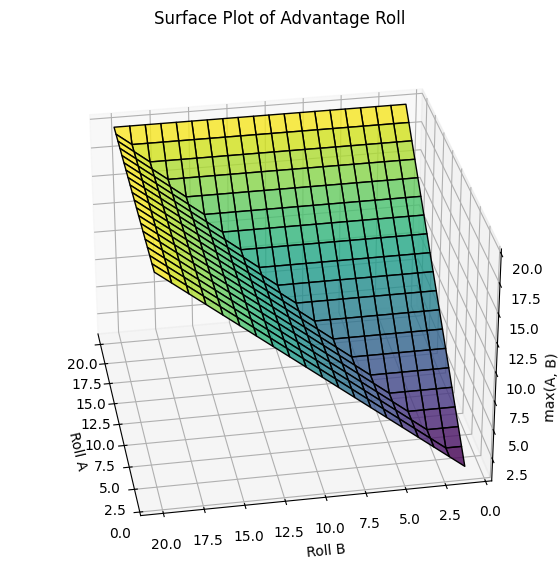

In [ ]:
# Expected Value
a = np.arange(1, 21)
b = np.arange(1, 21)
A, B = np.meshgrid(a, b)
X = np.maximum(A, B)
print(f'Expected value of max(a, b): {np.mean(X):.3f}')

# Surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, X, cmap='viridis', edgecolor='k', alpha=0.8)
ax.set_xlabel('Roll A')
ax.set_ylabel('Roll B')
ax.set_zlabel('max(A, B)')
ax.set_title('Surface Plot of Advantage Roll')
ax.view_init(elev=30, azim=170)
plt.show()

## Effect of Advantage on Success / Failure

To more accurately explore the effect of advantage on the game, let's move past EV and explore how advantage affects the probability of a roll exceeding the Difficulty Class (DC) of the action.

The probability of failure with a modified roll, with modifier *m* and Difficulty Class *d* is

$$
p = \Pr(a + m \lt d), \quad a \sim \mathrm{Uniform}\{1, \dots, 20\}, \quad m, d \overset{\text{i.i.d.}}{\sim} \in \mathbb{Z}
$$

and the probability of failure / success with an advantaged roll is

$$
f = \Pr(Failure) = p^2
\\\\
s = \Pr(Success) = 1 -p^2
$$

By the Law of Iterated Expectations,

$$
\mathbb{E}[s] = \mathbb{E}_{m,d} \Big[ \mathbb{E}[s \mid m,d] \Big]
$$